In [ ]:
# Instalar librarias necesarias
import sys
!{sys.executable} -m pip install scikit-image
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pillow

In [393]:
#importar librerias 
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.filters import threshold_otsu
from skimage.measure import label

In [394]:
def assign(arr, x, y, value): # Función para asignar un valor a un arreglo bidimensional
    arr[x][y] = value

## Método para binarizar una imagen
$$S[x,y] = 0, E[x,y] < T$$
$$S[x,y] = 1, E[x,y] \geq T$$

Donde $T$ es el valor del umbral, en este caso se obtuvo con el método de Otsu.

$S$, es la imagen de salida

y $E$, la imagen de entrada


In [395]:
def thresholding(img, threshold): # Umbralización de una Imagen para obtener una imáegn binaria
    w, h = img.shape # Obtener la longitud del arreglo de la imágen w: ancho, h:largo
    thresholded_image = np.zeros((w, h)) # Crear un arreglo del tamaño de la imagen original inicializado en 0 para almacenar la imágen binaria
    binarization = lambda value: 0 if value < threshold else 1 # Función para obtener el valor de un pixel basandose en su valor original respecto al umbral
    [[assign(thresholded_image, i, j, binarization(img[i][j])) for j in range(h)] for i in range(w)] # Lista comprimida anidada para asignar los valores correspondientes al arreglo de la imágen binaria
    return thresholded_image

## Inversión de valores en imagen binaria",

$$S[x,y] = 1, E[x,y] = 0$$
$$S[x,y] = 0, E[x,y] = 1$$

$S$, es la imagen de salida

y $E$, la imagen de entrada

In [396]:
# Invertir Imágen
def inverse(img):
    w, h = img.shape # Obtener la longitud del arreglo de la imágen w: ancho, h:largo
    temp_image = np.zeros((w, h)) # Crear un arreglo del tamaño de la imagen original inicializado en 0 para almacenar la imágen filtrada
    [[assign(temp_image, i, j, 1) if img[i][j]==0 else None for j in range(h)] for i in range(w)] # Asignar el valor 1 solo a los pixeles que tengan el valor de 0 en la imágen original
    return temp_image

## Filtro morfológico erosión
$$X \bigotimes B \; = \{ d \in E^2: d+b\in X\; para\; cada\; b \in B\}$$

Donde $X$, es la imagen de entrada

$B$, el elemento estructural

In [397]:
# Función para eliminar los pixeles que no coinciden con el elemento estructural
def remove_structuring_element(img, filtered_image, structuring_element, structuring_element_sum, x, y, w, h, sew, seh, padw, padh):
    if sew%2==1 and seh%2==1: # Validar que las dimensiones del elemento estructural son impares
        for i in range(sew):
            for j in range(seh):
                pos_x = i + x - padw
                pos_y = j + y - padh
                if pos_x < 0 or pos_y < 0 or pos_x >= w or pos_y >= h: # Validar que el análisis no se salga de los bordes de la imágen
                    continue
                if structuring_element[i][j] > 0:
                    if np.sum(structuring_element*img[pos_x:pos_x+padw*2+1, pos_y:pos_y+padh*2+1]) != structuring_element_sum: # Validar que el pixel no es parte del elemento estructural en la imágen
                        filtered_image[pos_x][pos_y] = 0

def erosion(img, structuring_element): # Operador Morfológico Erosión
    w, h = img.shape # Obtener la longitud del arreglo de la imágen w: ancho, h:largo
    sew, seh = structuring_element.shape # Obtener la longitud del arreglo del elemento estructural kw: ancho, kh:largo
    padw = sew//2 # Obtener el padding necesario para aplicar el kernel en los extremos
    padh = seh//2
    filtered_image = np.copy(img) # Crear una copia del arreglo de la imágen original
    temp_image = np.pad(img,((padw, padw), (padh, padh)),'edge') # Crear una imágen temporal con un padding para poder aplicar el kernel
    structuring_element_sum = np.sum(structuring_element) # Obtener la suma de los valores del elemento estructural
    # Aplicar la función de remover elemento estructural a todos los pixeles de la imágen
    [[remove_structuring_element(temp_image, filtered_image, structuring_element, structuring_element_sum, i, j, w, h, sew, seh, padw, padh) for j in range(h)] for i in range(w)]
    return filtered_image

## Filtro morfológico dilatación
$$X \bigoplus B = \{d \in E^2: d = x + b \; para \; cada\; x\in X\; y\; b\in B\}$$

Donde $X$, es la imagen de entrada

$B$, el elemento estructural

In [398]:
# Función para Unir el elemento estructural a la imagen en el pixel indicado (x, y)
def apply_structuring_element(img, structuring_element, x, y, w, h, sew, seh, padw, padh):
    if seh%2==1 and seh%2==1: # Validar que las dimensiones del elemento estructural son impares
        for i in range(sew):
            for j in range(seh):
                pos_x = i + x - padw
                pos_y = j + y -padh
                if pos_x < 0 or pos_y < 0 or pos_x >= w or pos_y >= h: # Validar que el análisis no se salga de los bordes de la imágen
                    continue
                # Asignación del valor del pixel respecto a los valores del elemento estructural y la imágen original
                img[pos_x][pos_y] = 1 if structuring_element[i][j] + img[pos_x][pos_y] > 0 else 0 

                
# Operador Morfológico Dilatación con elemento estructural variable
def dilation(img, structuring_element):
    w, h = img.shape # Obtener la longitud del arreglo de la imágen w: ancho, h:largo
    sew, seh = structuring_element.shape # Obtener la longitud del arreglo del elemento estructural kw: ancho, kh:largo
    filtered_image = np.zeros((w, h)) # Crear un arreglo del tamaño de la imagen original inicializado en 0 para almacenar la imágen filtrada
    padw = sew//2 # Obtener el padding necesario para aplicar el kernel en los extremos
    padh = seh//2
    # Aplicación de la función "aplicar elemento estructural" solo en los pixeles que no son 0
    [[apply_structuring_element(filtered_image, structuring_element, i, j, w, h, sew, seh, padw, padh) if img[i][j]!=0 else None for j in range(h)] for i in range(w)]
    return filtered_image

In [399]:
def low_pass(img, kernel): # Función de filtrado espacial paso baja con-kernel variable (x, y)
    w, h = img.shape # Obtener la longitud del arreglo de la imágen w: ancho, h:largo
    kw, kh = kernel.shape # Obtener la longitud del arreglo del kernel kw: ancho, kh:largo
    if kw % 2==1 and kh%2 ==1: # Validar que las dimensiones del arreglo sean impares
        padw = kw//2 # Obtener el padding necesario para aplicar el kernel en los extremos
        padh = kh//2 
        temp_img = np.pad(img,((padw, padw), (padh, padh)),'edge') # Crear una imágen temporal con un padding para poder aplicar el kernel
        filtered_image = np.zeros((w, h)) # Crear un arreglo del tamaño de la imagen original inicializado en 0 para almacenar la imágen filtrada
        total = kernel.sum() # Obtener la suma de los valores del kernel para realizar el promedio
        weighted_average = lambda x,y: int(np.sum(kernel*temp_img[x:x+padw*2+1, y:y+padh*2+1])/total) # Función para obtener la sumatoria del producto de los arreglos de la parte analizada de la imagen y el kernel
        [[assign(filtered_image, i, j, weighted_average(i, j)) for j in range(h)] for i in range(w)] # Lista comprimida anidada para asignar los valores correspondientes a la imágen filtrada
        return filtered_image
    return img

def high_pass(img, kernel): # Función de filtrado espacial paso-alta con kernel variable (x, y)
    w, h = img.shape # Obtener la longitud del arreglo de la imágen w: ancho, h:largo
    kw, kh = kernel.shape # Obtener la longitud del arreglo del kernel kw: ancho, kh:largo
    filtered_image = np.zeros((w, h)) # Crear un arreglo del tamaño de la imagen original inicializado en 0 para almacenar la imágen filtrada
    if kw%2!=0 and kh%2!=0: # Validar que las dimensiones del kernel son impares
        padw = kw//2 # Obtener el padding necesario para aplicar el kernel en los extremos
        padh = kh//2
        temp_img = np.pad(img,((padw, padw), (padh, padh)),'edge') # Crear una imágen temporal con un padding para poder aplicar el kernel
        # Función para obtener la sumatoria del producto de los arreglos de la parte analizada de la imagen y el kernel
        product_sum = lambda x,y: 1 if np.sum(kernel*temp_img[x:x+padw*2+1, y:y+padh*2+1])!=0 else 0 # El kernel se encuentra posicionado con el pixel analizado en su centro
    else:
        temp_img = np.pad(img,((0, kw), (0, kh)),'edge') # Crear una imágen temporal con un padding para poder aplicar el kernel
        # Función para obtener la sumatoria del producto de los arreglos de la parte analizada de la imagen y el kernel
        product_sum = lambda x,y: 1 if np.sum(kernel*temp_img[x:x+kw, y:y+kh])!=0 else 0 # El kernel se encuentra posicionado con el pixel analizado en la posición 0,0
    [[assign(filtered_image, i, j, product_sum(i, j)) for j in range(h)] for i in range(w)] # Lista comprimida anidada para asignar los valores correspondientes a la imágen filtrada
    return filtered_image

def roberts(img, orientation=True): # Operador de Roberts para detección de bordes diagonales
    if orientation:
        kernel = np.array([[1, 0],[0, -1]]) # Kernel para detección de bordes en un ángulo de 135°
    else:
        kernel = np.array([[0, 1], [-1, 0]]) # Kernel para detección de bordes en un ángulo de 45°
    return high_pass(img, kernel) # Aplicación del filtro paso alta con el kernel correspondiente

def prewitt(img, orientation=True): # Operador de Prewitt para la detección de bordes verticales y horizontales
    if orientation:
        kernel = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]) # Kernel para detección de bordes verticales
    else:
        kernel = np.array([[ 1,  1,  1], [ 0,  0,  0], [-1, -1, -1]]) # Kernel para detección de bordes horizontales
    return high_pass(img, kernel) # Aplicación del filtro paso alta con el kernel correspondiente

# Operador de Sobel para la detección de bordes verticales y horizontales
# A diferencia de Prewitt, este operador da un mayor peso a los pixeles más cercanos al pixel de interés
def sobel(img, orientation=True):
    if orientation:
        kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) # Kernel para detección de bordes verticales
    else:
        kernel = np.array([[ 1,  2,  1], [ 0,  0,  0], [-1, -2, -1]]) # Kernel para detección de bordes horizontales
    return high_pass(img, kernel) # Aplicación del filtro paso alta con el kernel correspondiente

# Operador Morfológico de Cerradura con elemento estructural variable
# Es el resultado de aplicar una erosión a la dilatación de la imágen original
def closing(img, structuring_element, dilated_img=None):
    if dilated_img is None:
        return erosion(dilation(img, structuring_element), structuring_element)
    return erosion(dilated_img, structuring_element)

# Operador Morfológico de Apertura con elemento estructural variable
# Es el resultado de aplicar una dilatación a la erosión de la imágen original
def opening(img, structuring_element, eroded_img=None):
    if eroded_img is None:
        return dilation(erosion(img, structuring_element), structuring_element)
    return dilation(eroded_img, structuring_element)

# Operador Morfológico Gradiente con elemento estructural variable
# Es el resultado de la resta de la dilatación y la erosión de la imágen original
def gradient(img, structuring_element, dilated_img=None, eroded_img=None):
    dilated = dilated_img
    if dilated is None:
        dilated = dilation(img, structuring_element)
    eroded = eroded_img
    if eroded is None:
        eroded = erosion(img, structuring_element)
    return  dilated - eroded 

# Operador Morfológico TopHat con elemento estructural variable
# Es el resultado de la resta de la imagen original y la apertura de la misma
def tophat(img, structuring_element, opened_img=None):
    opened = opened_img
    if opened is None:
        opened = opening(img, structuring_element)
    return img-opened

In [400]:
def show_images(w, h, img1, title1, img2, title2, img3, title3, img4, title4, img5, title5, img6, title6):
    fig, (ax1, ax2, ax3) = plt.subplots(3,2, figsize=(w, h))
    ax1[0].title.set_text(title1)
    ax1[0].axis("off")
    ax1[0].imshow(img1, cmap='gray')
    ax1[1].title.set_text(title2)
    ax1[1].axis("off")
    ax1[1].imshow(img2, cmap='gray')
    ax2[0].title.set_text(title3)
    ax2[0].axis("off")
    ax2[0].imshow(img3, cmap='gray')
    ax2[1].title.set_text(title4)
    ax2[1].axis("off")
    ax2[1].imshow(img4, cmap='gray')
    ax3[0].title.set_text(title5)
    ax3[0].axis("off")
    ax3[0].imshow(img5, cmap='gray')
    ax3[1].title.set_text(title6)
    ax3[1].axis("off")
    ax3[1].imshow(img6, cmap='gray')
    

# Función para leer imágen y limpiar para el reconocimiento de caracteres
def clear_image(path, thresh_var=0, w=20, h=30, opening_structuring_element=np.ones((5,5)), closing_structuring_element=np.ones((5,5)), gradient_structuring_element=np.ones((3,3))):
    imagen_o = Image.open(path) # Leer imagen original
    imagen = imagen_o.convert("L") # Convertir imagen a escala de grises para tratar un solo canal
    thresh = threshold_otsu(np.asarray(imagen)) # Obtener el umbral de gris
    thresh += thresh_var # Variar el umbral con el parametro dado
    imagen_bn = thresholding(np.asarray(imagen), thresh) # Umbralizar imágen
    imagen_bn = inverse(imagen_bn) # Invertir Imágen
    imagen_con_apertura = imagen_bn # Aperturar imágen solo si el elemento estructural para apertura es proporcionado
    if opening_structuring_element is not None:
        imagen_con_apertura = opening(imagen_bn, opening_structuring_element) # Aperturar imágen
    imagen_con_clausura = imagen_con_apertura # Cerrar imágen solo si el elemento estructural para apertura es proporcionado
    if closing_structuring_element is not None:
        imagen_con_clausura = closing(imagen_con_apertura, closing_structuring_element)
    suavizado = low_pass(imagen_con_clausura, np.ones((3,3))) # Suavizar Imágen
    afilado = high_pass(imagen_con_clausura, np.ones((3,3))) # Afilar Imágen
    gradiente = gradient(imagen_con_clausura, gradient_structuring_element) # Operador Gradiente
    # Mostrar Imagenes en una matriz de (2,2)
    show_images(
        w, h,
        imagen_o, "Imagen Original", imagen_bn, "Imagen Binarizada",
        imagen_con_clausura, "Imágen con Apertura y Clausura",
        gradiente, "Imágen con el operador morfolófico gradiente",
        suavizado, "Imágen suavizada con el filtro espacial paso baja", afilado, "Imágen Afilada con el filtro espacial paso alta")


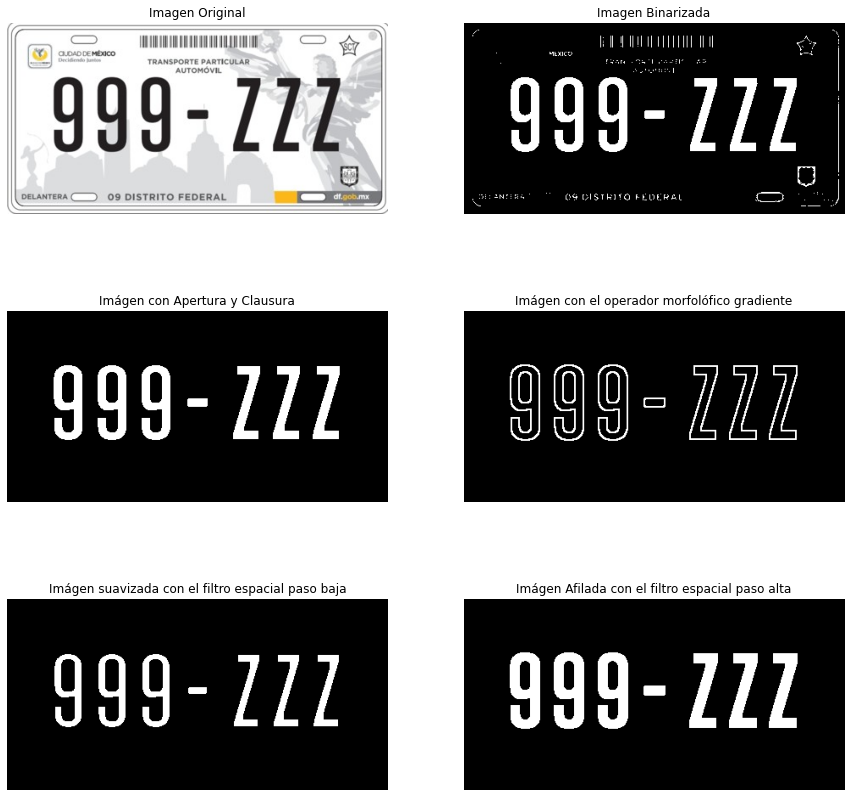

In [380]:
# Aplicar Filtros a Imágen monedas
clear_image('imagenes/placas.jpg', -40, 15,15)

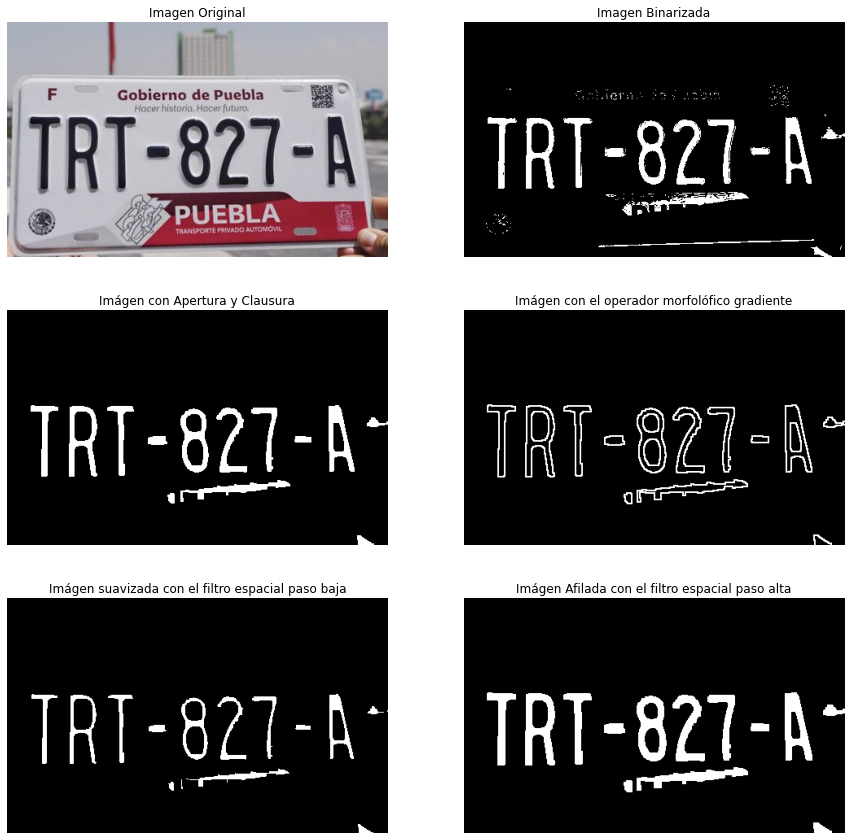

In [381]:
# Aplicar Filtros a Imágen monedas
clear_image('imagenes/placas_puebla.jpg', -80, 15, 15, np.ones((3,3)), np.ones((7,7)))

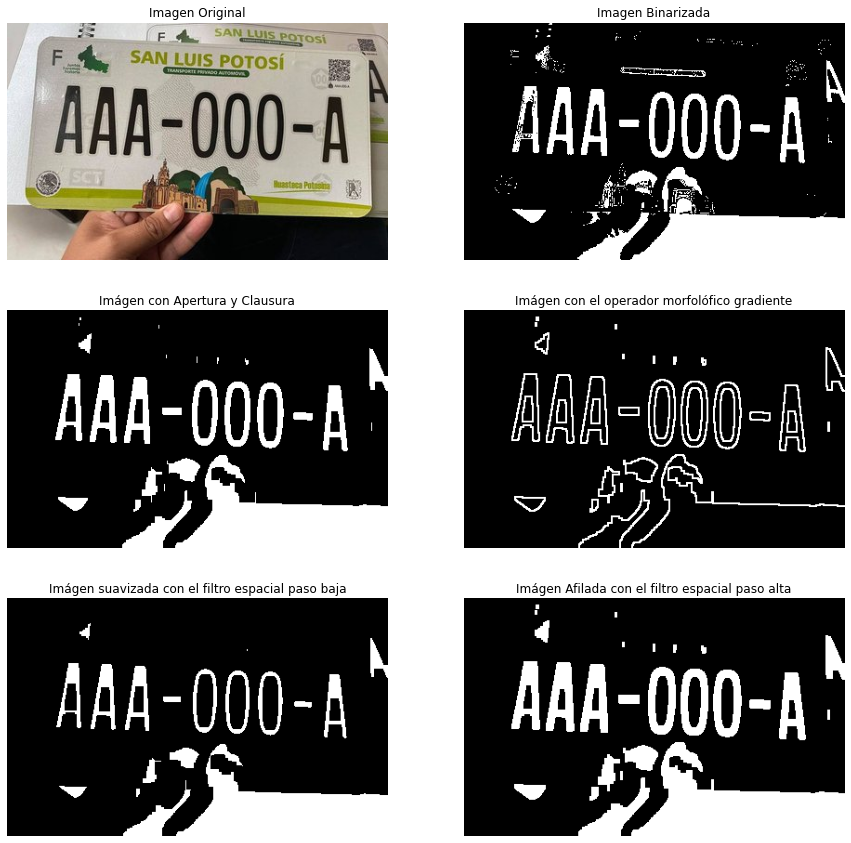

In [382]:
# Aplicar Filtros a Imágen monedas
clear_image('imagenes/placas_san_luis.jpg', -45, 15, 15, np.ones((3,1)), np.ones((9,7)))

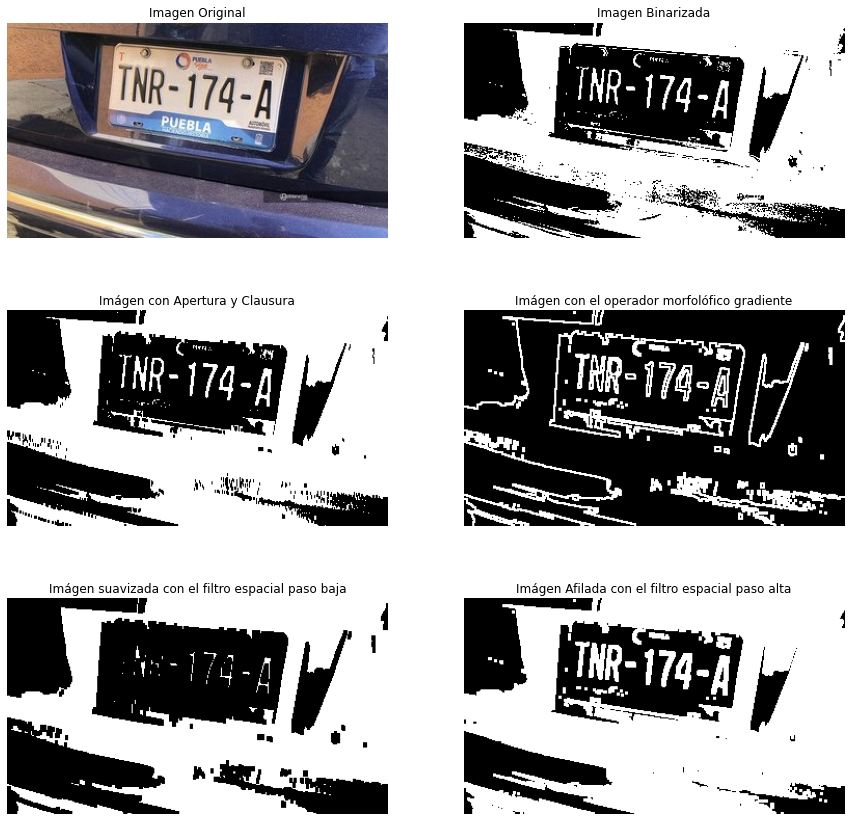

In [401]:
# Aplicar Filtros a Imágen monedas
clear_image('imagenes/placas_en_auto.jpg', -5, 15, 15, None, np.ones((3,1)))